# Problem statement

-Identifying costumer churn in advance and retain existing costumers to increase their lifetime value  and avoid losing revenue that results from a customer abandoning the bank.

-learn from past customer behaviour and external triggers that led to churn and use this learning to predict the future occurrence of a churn.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.metrics import recall_score,classification_report
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data = pd.read_csv('Churn Modeling.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
data.shape

(10000, 14)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
def camel_to_snake(string):  
    if '-' in string:
        strg = re.sub('[-]+','_',string)
        result = re.sub('[_]+','_',''.join([i if i.islower() else '_'+i for i in strg])).lower().strip('_')
    else:    
        result = re.sub('[_]+','_',''.join([i if i.islower() else '_'+i for i in string])).lower().strip('_')
    
    return result

In [8]:
df_column = pd.DataFrame()
df_column['col']=data.columns
column_list = (df_column['col'].apply(camel_to_snake))
column_list

0           row_number
1          customer_id
2              surname
3         credit_score
4            geography
5               gender
6                  age
7               tenure
8              balance
9      num_of_products
10         has_cr_card
11    is_active_member
12    estimated_salary
13              exited
Name: col, dtype: object

In [9]:
data.columns = column_list

In [10]:
# No missing values

In [11]:
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object', name='col')

In [12]:
df= data.drop(['row_number', 'customer_id', 'surname'],axis = 1)

In [13]:
df.head()

col,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [14]:
# 1. Outliers upper tail and lower tail

# EDA

In [15]:
df['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

In [16]:
# Class 0
(7963/(7963+2037))*100

79.63

In [17]:
#class 1
(2037/(7963+2037))*100

20.369999999999997

In [18]:
# Imbalanced data

In [19]:
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object', name='col')

# CreditScore

In [20]:
df['credit_score'].nunique()

460

<AxesSubplot:xlabel='credit_score', ylabel='Density'>

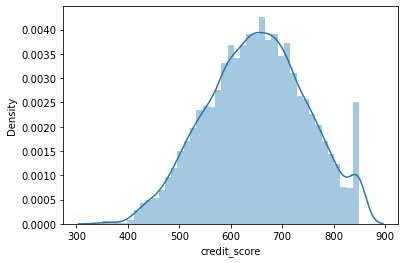

In [21]:
sns.distplot(df['credit_score'])

<AxesSubplot:xlabel='exited', ylabel='credit_score'>

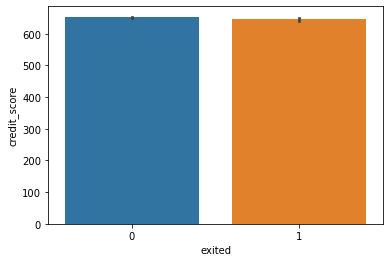

In [22]:
sns.barplot(df['exited'],df['credit_score'])

<AxesSubplot:xlabel='credit_score'>

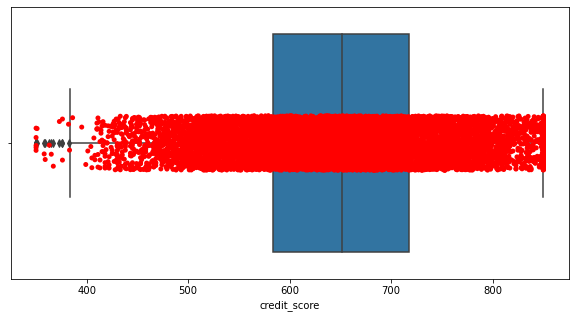

In [23]:
plt.figure(figsize=(10,5))
sns.boxplot(df['credit_score'])
sns.stripplot(df['credit_score'],color = 'red')

In [24]:
q1 = df['credit_score'].quantile(0.25)
q3 = df['credit_score'].quantile(0.75)
iqr = q3-q1
ut = q3+1.5*iqr
lt = q1-1.5*iqr
print(ut)
print(lt)

919.0
383.0


In [25]:
cs_outlier_ind = np.where(df['credit_score']<lt)[0]

In [26]:
cs_outlier_ind

array([   7,  942, 1193, 1405, 1631, 1838, 1962, 2473, 2579, 8154, 8723,
       8762, 9210, 9356, 9624], dtype=int64)

In [27]:
df['credit_score'][cs_outlier_ind]

7       376
942     376
1193    363
1405    359
1631    350
1838    350
1962    358
2473    351
2579    365
8154    367
8723    350
8762    350
9210    382
9356    373
9624    350
Name: credit_score, dtype: int64

In [28]:
df['credit_score'][cs_outlier_ind] = lt

In [29]:
df['credit_score'][cs_outlier_ind]

7       383
942     383
1193    383
1405    383
1631    383
1838    383
1962    383
2473    383
2579    383
8154    383
8723    383
8762    383
9210    383
9356    383
9624    383
Name: credit_score, dtype: int64

<AxesSubplot:xlabel='credit_score'>

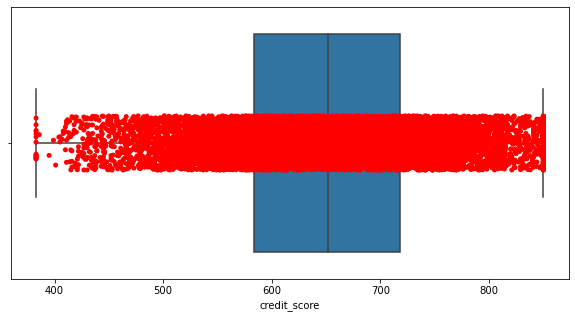

In [30]:
plt.figure(figsize=(10,5))
sns.boxplot(df['credit_score'])
sns.stripplot(df['credit_score'],color = 'red')

In [31]:
df.head()

col,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Geography

In [32]:
df['geography'].nunique()

3

In [33]:
df['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

([<matplotlib.patches.Wedge at 0x2151ff5fc40>,
 [Text(-0.0048380159962871415, 1.0999893606763749, 'France'),
  Text(-0.7687238787085311, -0.786805947043686, 'Germany'),
  Text(0.7834173384027578, -0.7721769705773016, 'Spain')],
 [Text(-0.002638917816156622, 0.599994196732568, '50.14%'),
  Text(-0.4193039338410169, -0.4291668802056469, '25.09%'),
  Text(0.42731854821968607, -0.42118743849671, '24.77%')])

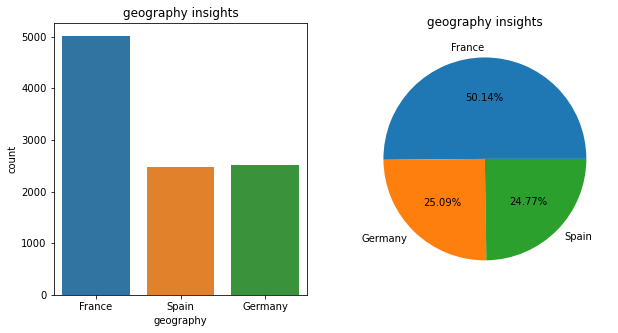

In [34]:
f = plt.figure(figsize=(10,5))
f.add_subplot(1,2,1)
plt.title('geography insights')
sns.countplot(df['geography'])
f.add_subplot(1,2,2)
plt.title('geography insights')
plt.pie(df['geography'].value_counts().values,labels=df['geography'].value_counts().index,
       autopct='%1.2f%%')

In [35]:
# Around half the accounts are from France

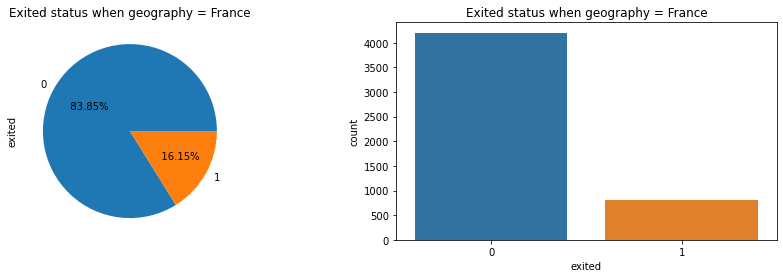

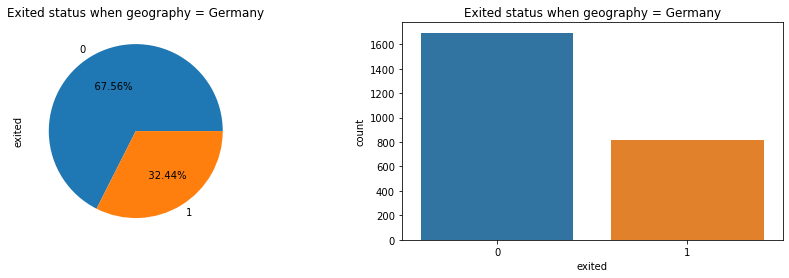

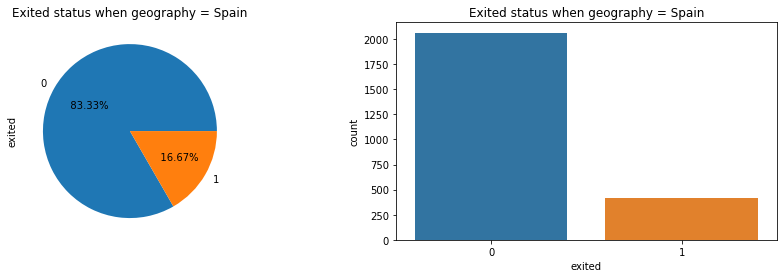

In [36]:
a=1
for i in sorted(list(df['geography'].value_counts().index)):   
    if a<=df['geography'].nunique():  
        f = plt.figure(figsize=(15,4))
        f.add_subplot(1,2,1)
        plt.title(f"Exited status when geography = {i}")
        df.loc[(df['geography']==i)]['exited'].value_counts().plot(kind='pie',autopct='%8.2f%%')   
        f.add_subplot(1,2,2)
        plt.title(f"Exited status when geography = {i}")
        sns.countplot(df.loc[(df['geography']==i)]['exited'])
        a+=1

In [37]:
# More people are exiting from Germany

In [38]:
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object', name='col')

# Gender

([<matplotlib.patches.Wedge at 0x2152024dbe0>,
 [Text(-0.1573859183753976, 1.088682539906438, 'Male'),
  Text(0.1573859183753977, -1.088682539906438, 'Female')],
 [Text(-0.08584686456839868, 0.5938268399489661, '54.57%'),
  Text(0.08584686456839873, -0.5938268399489661, '45.43%')])

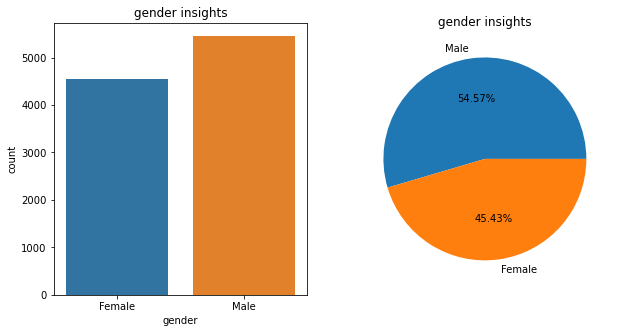

In [39]:
f = plt.figure(figsize=(10,5))
f.add_subplot(1,2,1)
plt.title('gender insights')
sns.countplot(df['gender'])
f.add_subplot(1,2,2)
plt.title('gender insights')
plt.pie(df['gender'].value_counts().values,labels=df['gender'].value_counts().index,
       autopct='%1.2f%%')

In [40]:
# Male accounts are comparatively more than female

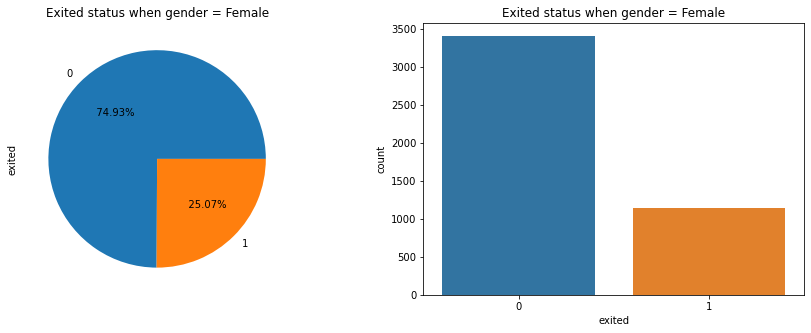

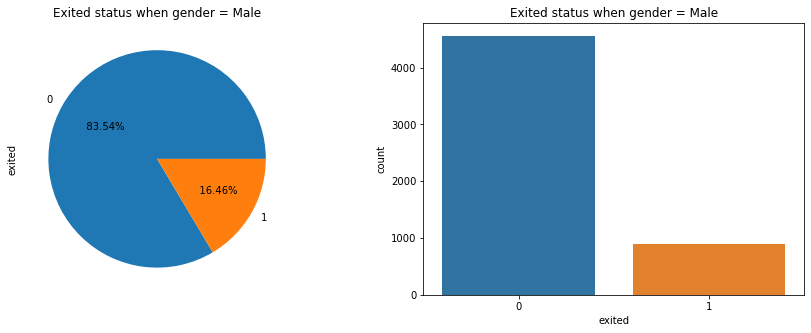

In [41]:
a=1
for i in sorted(list(df['gender'].value_counts().index)):   
    if a<=df['gender'].nunique():  
        f = plt.figure(figsize=(15,5))
        f.add_subplot(1,2,1)
        plt.title(f"Exited status when gender = {i}")
        df.loc[(df['gender']==i)]['exited'].value_counts().plot(kind='pie',autopct='%8.2f%%')   
        f.add_subplot(1,2,2)
        plt.title(f"Exited status when gender = {i}")
        sns.countplot(df.loc[(df['gender']==i)]['exited'])
        a+=1

In [42]:
# Exit rate of females is more

# Age

In [43]:
df['age'].nunique()

70

In [44]:
df['age'].unique()

array([42, 41, 39, 43, 44, 50, 29, 27, 31, 24, 34, 25, 35, 45, 58, 32, 38,
       46, 36, 33, 40, 51, 61, 49, 37, 19, 66, 56, 26, 21, 55, 75, 22, 30,
       28, 65, 48, 52, 57, 73, 47, 54, 72, 20, 67, 79, 62, 53, 80, 59, 68,
       23, 60, 70, 63, 64, 18, 82, 69, 74, 71, 76, 77, 88, 85, 84, 78, 81,
       92, 83], dtype=int64)

In [45]:
df['age'].value_counts()

37    478
38    477
35    474
36    456
34    447
     ... 
92      2
82      1
88      1
85      1
83      1
Name: age, Length: 70, dtype: int64

<AxesSubplot:xlabel='age', ylabel='Density'>

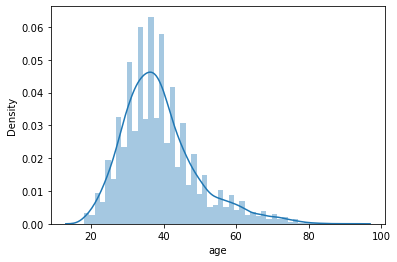

In [46]:
sns.distplot(df['age'])

In [47]:
dummy = df.copy()
dummy["age_reworked"] = np.where((dummy.age >= 15) & (dummy.age < 25),"15-25"
                                 ,np.where((dummy.age >= 25) & (dummy.age < 35),"25-35",
                                  np.where((dummy.age >= 35) & (dummy.age < 45),"35-45",
                                  np.where((dummy.age >= 45) & (dummy.age < 55),"45-55",
                                  np.where((dummy.age >= 55) & (dummy.age < 65),"55-65",
                                  np.where((dummy.age >= 65) & (dummy.age < 75),"65-75",
                                  np.where((dummy.age >= 75) & (dummy.age < 85),"75-85",'85+')))))))

In [48]:
dummy.head()

col,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,age_reworked
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,35-45
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,35-45
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,35-45
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,35-45
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,35-45


In [49]:
sorted(list(dummy['age_reworked'].unique()))

['15-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75-85', '85+']

<AxesSubplot:xlabel='age_reworked', ylabel='count'>

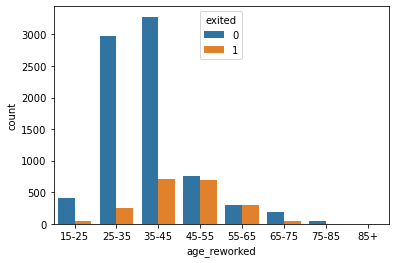

In [50]:
sns.countplot(dummy['age_reworked'],order =sorted(list(dummy['age_reworked'].unique())),
              hue = df['exited'])

<AxesSubplot:xlabel='age', ylabel='Density'>

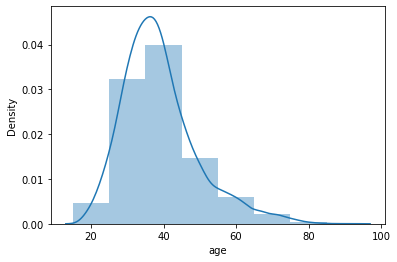

In [51]:
sns.distplot(df['age'],bins = np.arange(15,90,10))

In [52]:
# More accounts belongs` to 25 to 45 age group

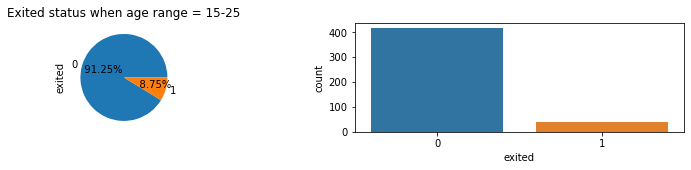

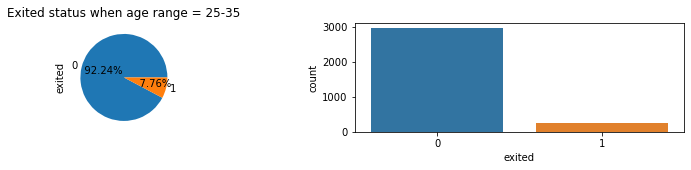

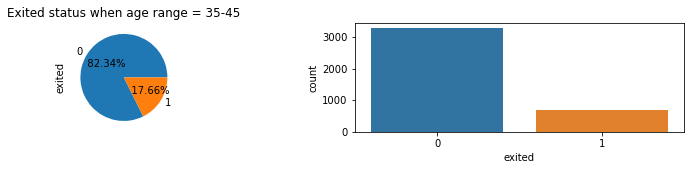

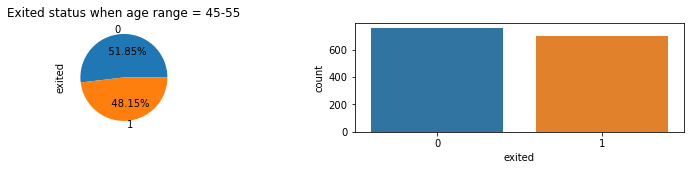

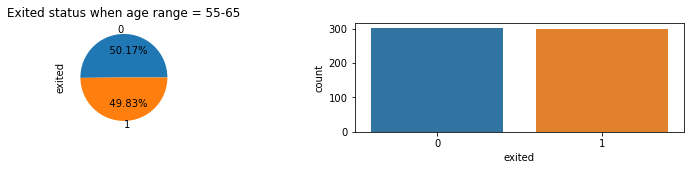

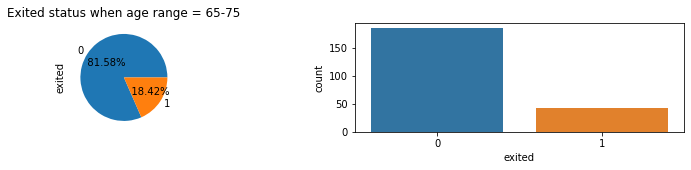

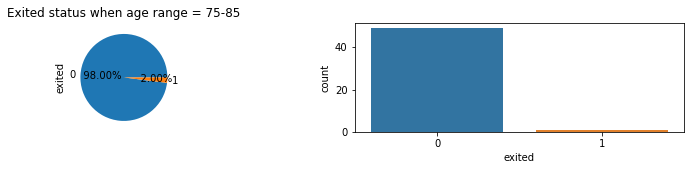

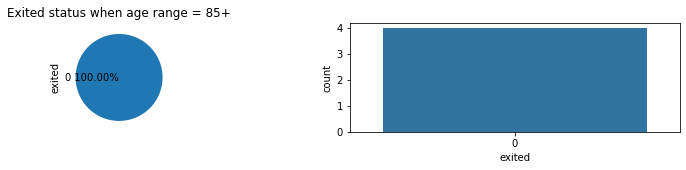

In [53]:
a=1
for i in sorted(list(dummy['age_reworked'].value_counts().index)):   
    if a<=dummy['age_reworked'].nunique():  
        f = plt.figure(figsize=(13,2))
        f.add_subplot(1,2,1)
        plt.title(f"Exited status when age range = {i}")
        df.loc[(dummy['age_reworked']==i)]['exited'].value_counts().plot(kind='pie',autopct='%8.2f%%')   
        f.add_subplot(1,2,2)
        sns.countplot(dummy.loc[(dummy['age_reworked']==i)]['exited'])
        a+=1

In [54]:
# Exit rate is more in age group 35 to 75
# highest in age group 45 to 65

<AxesSubplot:xlabel='age_reworked', ylabel='credit_score'>

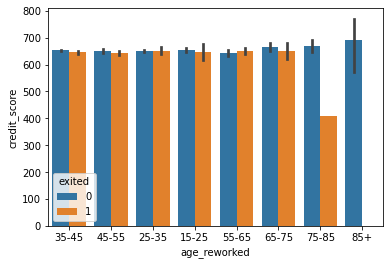

In [55]:
sns.barplot(x = 'age_reworked' , y = 'credit_score', data=dummy,hue = 'exited')

<AxesSubplot:xlabel='age_reworked', ylabel='Count'>

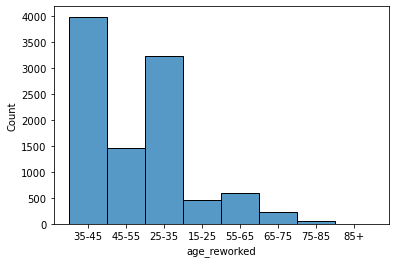

In [56]:
sns.histplot(dummy['age_reworked'])

<AxesSubplot:xlabel='age'>

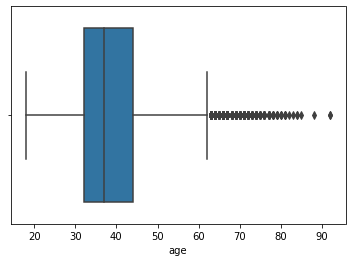

In [57]:
sns.boxplot(df['age'])

In [58]:
from copy import deepcopy

In [59]:
dff = deepcopy(df)

In [60]:
dff

col,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [61]:
q1 = dff['age'].quantile(0.25)
q3 = dff['age'].quantile(0.75)
iqr = q3 -q1
ut = q3+1.5*iqr
lt = q1-1.5*iqr

In [62]:
outliers_ind = np.where(df['age']>ut)[0]
outliers_ind
dff['age'][outliers_ind]

58      66
85      75
104     65
158     73
181     65
        ..
9753    68
9765    64
9832    64
9894    77
9936    77
Name: age, Length: 359, dtype: int64

In [63]:
dff['age'].median()

37.0

In [64]:
dff['age'][outliers_ind] = ut

In [65]:
dff['age'][outliers_ind]

58      62
85      62
104     62
158     62
181     62
        ..
9753    62
9765    62
9832    62
9894    62
9936    62
Name: age, Length: 359, dtype: int64

<AxesSubplot:xlabel='age', ylabel='Count'>

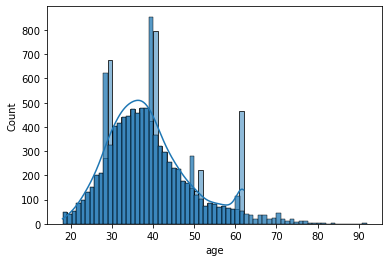

In [66]:
sns.histplot(dff['age'],kde=True)
sns.histplot(df['age'])

<AxesSubplot:xlabel='age'>

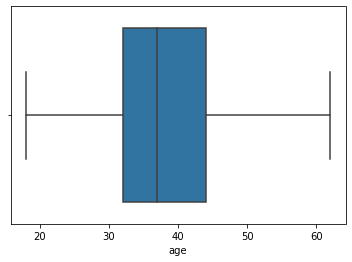

In [67]:
sns.boxplot(dff['age'])

In [68]:
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object', name='col')

In [69]:
q1 = df['age'].quantile(0.25)
q3 = df['age'].quantile(0.75)
iqr = q3 -q1
ut = q3+1.5*iqr
lt = q1-1.5*iqr
outliers_ind = np.where(df['age']>ut)[0]
outliers_ind
df['age'][outliers_ind]
df['age'][outliers_ind] = ut

# Tenure

In [70]:
df['tenure'].nunique()

11

In [71]:
df['tenure'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: tenure, dtype: int64

Text(0, 0.5, 'No. of accounts')

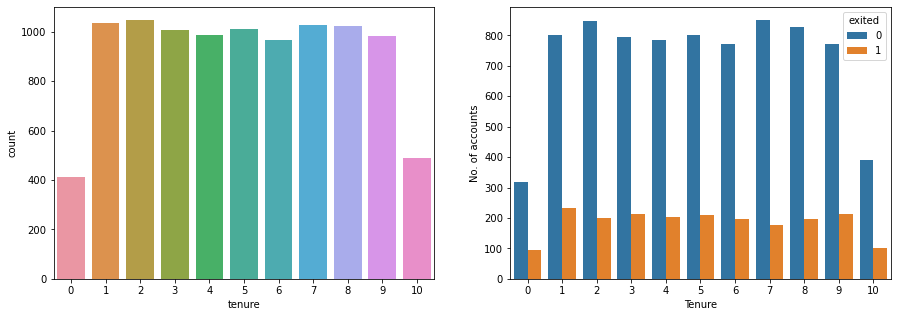

In [72]:
f = plt.figure(figsize = (15,5))
f.add_subplot(1,2,1)
sns.countplot(df['tenure'])
f.add_subplot(1,2,2)

sns.countplot(df['tenure'],hue =df['exited'])
plt.xlabel("Tenure")
plt.ylabel("No. of accounts")

In [73]:
# In all tenure the people are exiting the bank
# Less number of accounts having less than one tenure and more than 10 tenure

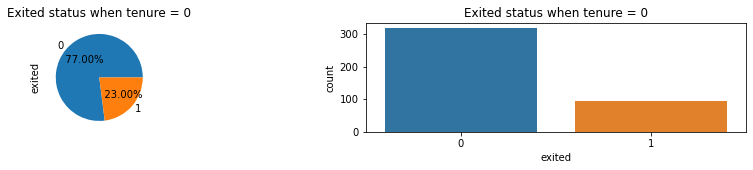

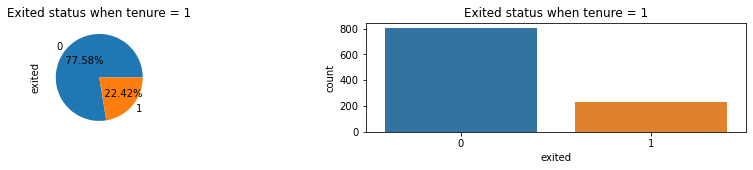

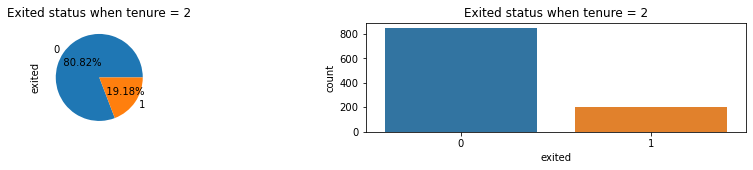

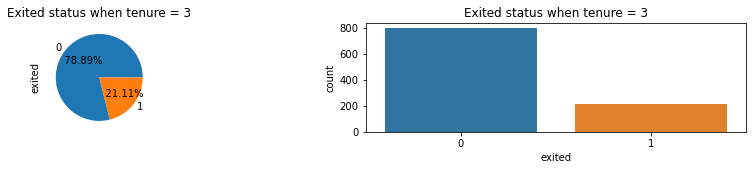

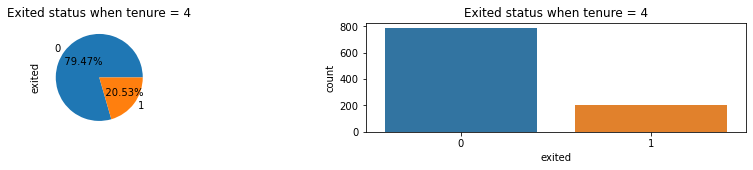

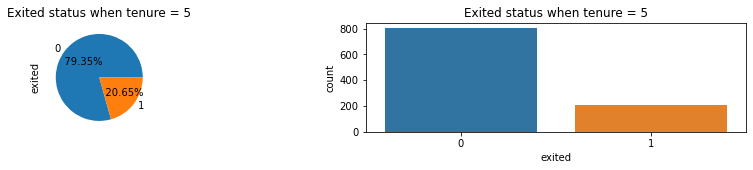

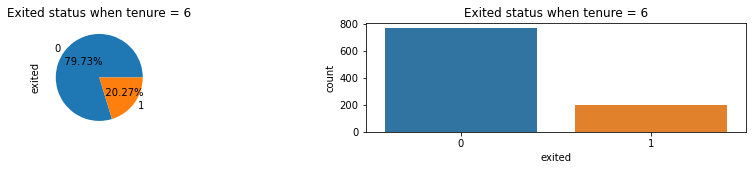

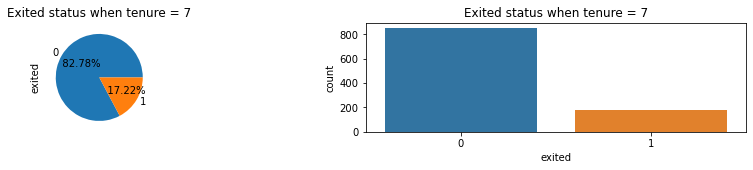

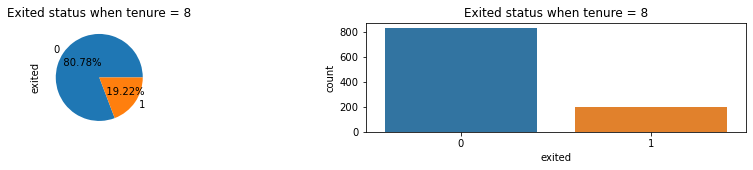

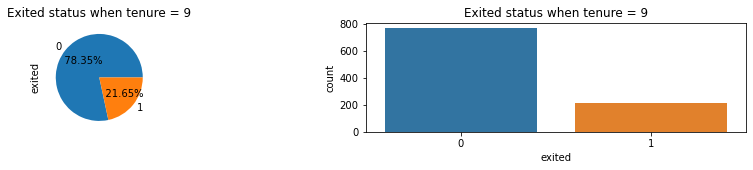

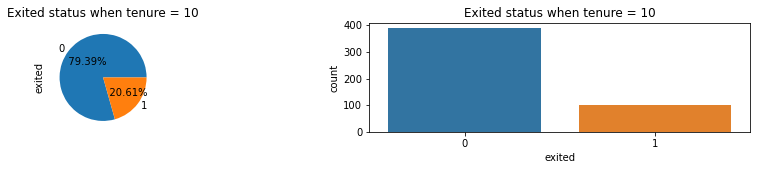

In [74]:
a=1
for i in sorted(list(df['tenure'].value_counts().index)):   
    if a<=df['tenure'].nunique():  
        f = plt.figure(figsize=(15,2))
        f.add_subplot(1,2,1)
        plt.title(f"Exited status when tenure = {i}")
        df.loc[(df['tenure']==i)]['exited'].value_counts().plot(kind='pie',autopct='%8.2f%%')   
        f.add_subplot(1,2,2)
        plt.title(f"Exited status when tenure = {i}")
        sns.countplot(df.loc[(df['tenure']==i)]['exited'])
        a+=1

<AxesSubplot:xlabel='tenure', ylabel='balance'>

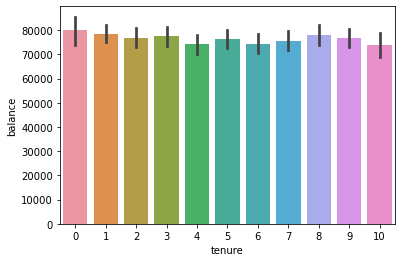

In [75]:
sns.barplot(df.tenure, df.balance)

<AxesSubplot:xlabel='tenure', ylabel='balance'>

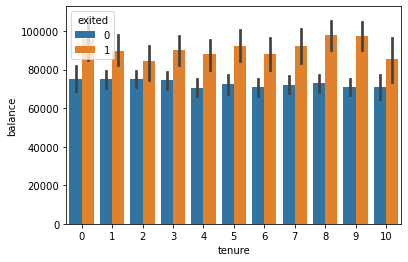

In [76]:
sns.barplot(df.tenure, df.balance , hue = df.exited)

In [77]:
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object', name='col')

In [78]:
df_exited = df[df['exited']==1]

<AxesSubplot:xlabel='num_of_products', ylabel='Count'>

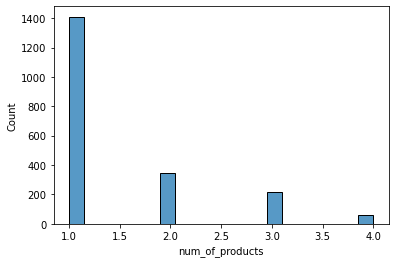

In [79]:
sns.histplot(df_exited['num_of_products'])

<AxesSubplot:xlabel='num_of_products', ylabel='balance'>

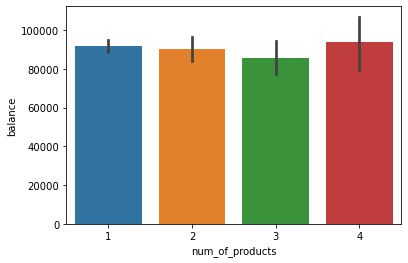

In [80]:
sns.barplot(df_exited['num_of_products'],df_exited['balance'])

In [81]:
# Exit rate is comparatively higher for tenure = 0
# For all other the rate is almost same

In [82]:
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object', name='col')

# Balance

In [83]:
df['balance'].nunique()

6382

In [84]:
df['balance']

0            0.00
1        83807.86
2       159660.80
3            0.00
4       125510.82
          ...    
9995         0.00
9996     57369.61
9997         0.00
9998     75075.31
9999    130142.79
Name: balance, Length: 10000, dtype: float64

<AxesSubplot:xlabel='balance', ylabel='Count'>

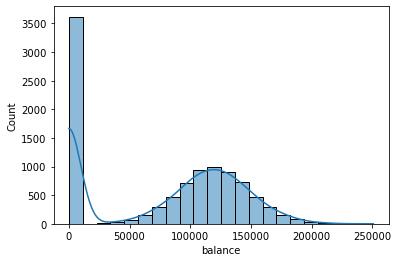

In [85]:
sns.histplot(df['balance'],kde=True)

<AxesSubplot:xlabel='balance'>

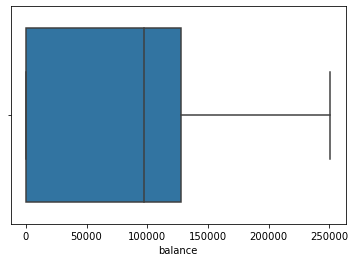

In [86]:
sns.boxplot(df['balance'])

In [87]:
df[df['balance']==0].shape

(3617, 11)

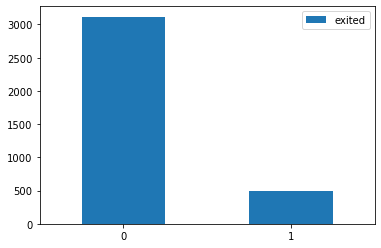

In [88]:
df[df['balance']==0]['exited'].value_counts().plot(kind='bar',rot=0)
plt.legend()

In [89]:
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object', name='col')

<AxesSubplot:xlabel='is_active_member', ylabel='estimated_salary'>

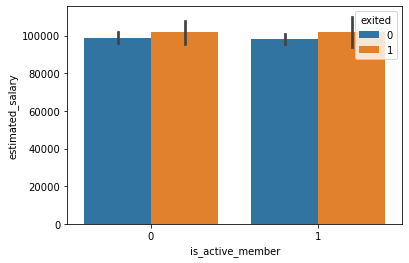

In [90]:
sns.barplot(df[df['balance']==0]['is_active_member'],df['estimated_salary'],hue=df['exited'])

<AxesSubplot:>

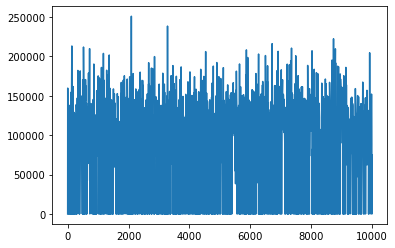

In [91]:
df_exited['balance'].plot()

# num_of_products

In [92]:
df['num_of_products'].nunique()

4

In [93]:
df['num_of_products'].nunique()

4

In [94]:
df['num_of_products'].value_counts()

1    5084
2    4590
3     266
4      60
Name: num_of_products, dtype: int64

In [95]:
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object', name='col')

<AxesSubplot:xlabel='num_of_products', ylabel='count'>

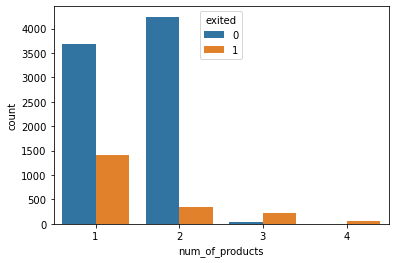

In [96]:
sns.countplot(df['num_of_products'],hue =df['exited'])

<AxesSubplot:ylabel='num_of_products'>

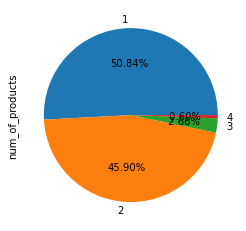

In [97]:
df['num_of_products'].value_counts().plot(kind='pie', autopct = "%5.2f%%")

In [98]:
df2 = df[df['exited']==1]

<AxesSubplot:ylabel='num_of_products'>

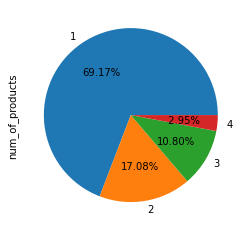

In [99]:
df2['num_of_products'].value_counts().plot(kind='pie', autopct = "%5.2f%%")

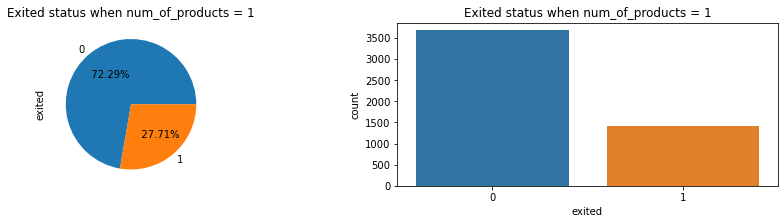

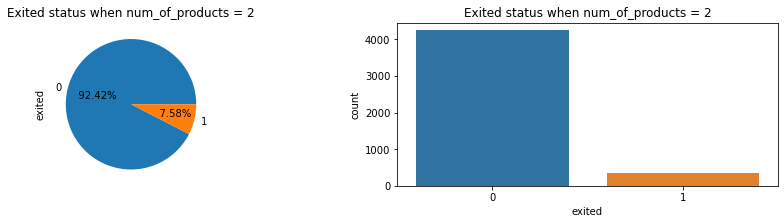

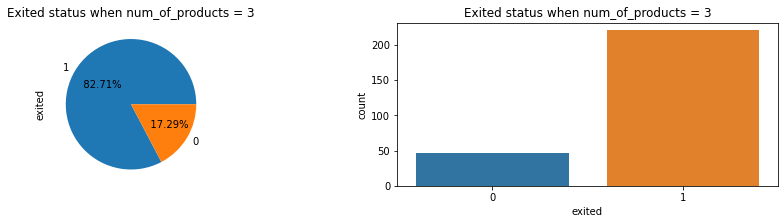

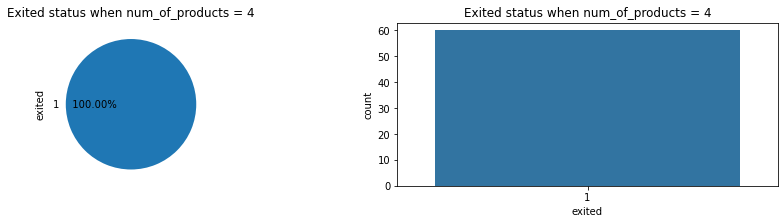

In [100]:
a=1
for i in sorted(list(df['num_of_products'].value_counts().index)):   
    if a<=df['num_of_products'].nunique():  
        f = plt.figure(figsize=(15,3))
        f.add_subplot(1,2,1)
        plt.title(f"Exited status when num_of_products = {i}")
        df.loc[(df['num_of_products']==i)]['exited'].value_counts().plot(kind='pie',autopct='%8.2f%%')   
        f.add_subplot(1,2,2)
        plt.title(f"Exited status when num_of_products = {i}")
        sns.countplot(df.loc[(df['num_of_products']==i)]['exited'])
        a+=1

In [101]:
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object', name='col')

# has_cr_card

In [102]:
df['has_cr_card'].nunique()

2

In [103]:
df['has_cr_card'].value_counts()

1    7055
0    2945
Name: has_cr_card, dtype: int64

<AxesSubplot:ylabel='has_cr_card'>

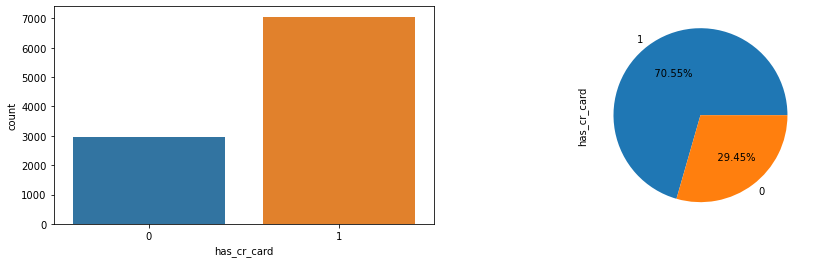

In [104]:
f = plt.figure(figsize=(15,4))
f.add_subplot(1,2,1)
sns.countplot(df['has_cr_card'])
f.add_subplot(1,2,2)
df['has_cr_card'].value_counts().plot(kind='pie',autopct='%8.2f%%')

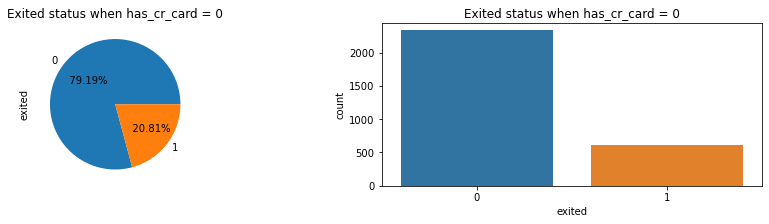

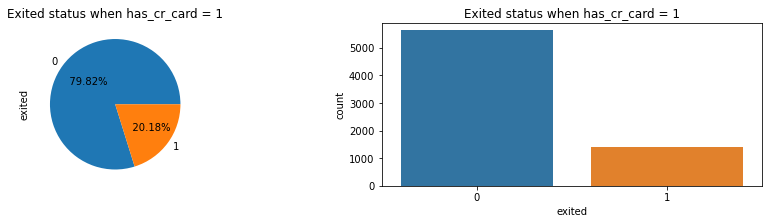

In [105]:
a=1
for i in sorted(list(df['has_cr_card'].value_counts().index)):   
    if a<=df['has_cr_card'].nunique():  
        f = plt.figure(figsize=(15,3))
        f.add_subplot(1,2,1)
        plt.title(f"Exited status when has_cr_card = {i}")
        df.loc[(df['has_cr_card']==i)]['exited'].value_counts().plot(kind='pie',autopct='%8.2f%%')   
        f.add_subplot(1,2,2)
        plt.title(f"Exited status when has_cr_card = {i}")
        sns.countplot(df.loc[(df['has_cr_card']==i)]['exited'])
        a+=1

In [106]:
# Exit % for both the cases are same 

In [107]:
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object', name='col')

# is_active_member

In [108]:
df['is_active_member'].nunique()

2

In [109]:
df['is_active_member'].value_counts()

1    5151
0    4849
Name: is_active_member, dtype: int64

<AxesSubplot:ylabel='is_active_member'>

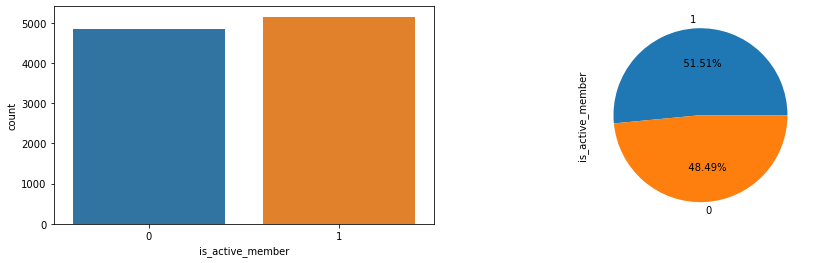

In [110]:
f = plt.figure(figsize=(15,4))
f.add_subplot(1,2,1)
sns.countplot(df['is_active_member'])
f.add_subplot(1,2,2)
df['is_active_member'].value_counts().plot(kind='pie',autopct='%8.2f%%')

In [111]:
# 48.49% accounts are inactive

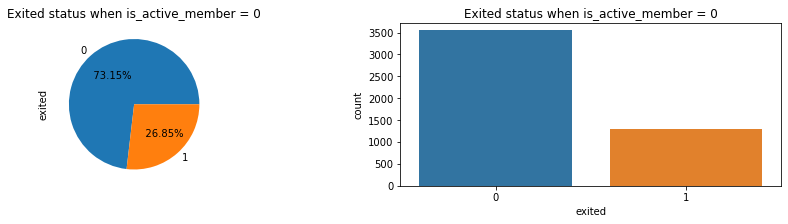

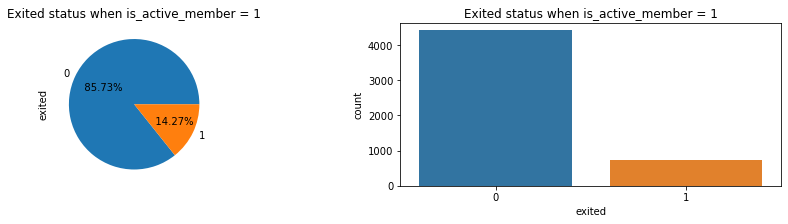

In [112]:
a=1
for i in sorted(list(df['is_active_member'].value_counts().index)):   
    if a<=df['is_active_member'].nunique():  
        f = plt.figure(figsize=(15,3))
        f.add_subplot(1,2,1)
        plt.title(f"Exited status when is_active_member = {i}")
        df.loc[(df['is_active_member']==i)]['exited'].value_counts().plot(kind='pie',autopct='%8.2f%%')   
        f.add_subplot(1,2,2)
        plt.title(f"Exited status when is_active_member = {i}")
        sns.countplot(df.loc[(df['is_active_member']==i)]['exited'])
        a+=1

<AxesSubplot:ylabel='is_active_member'>

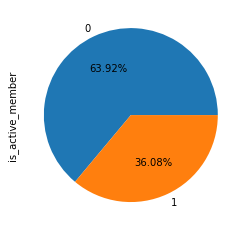

In [113]:
df[df['exited']==1]['is_active_member'].value_counts().plot(kind='pie',autopct = '%1.2f%%')

<AxesSubplot:ylabel='is_active_member'>

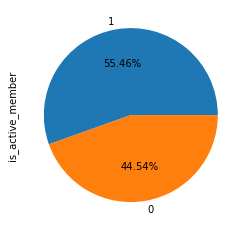

In [114]:
df[df['exited']==0]['is_active_member'].value_counts().plot(kind='pie',autopct = '%1.2f%%')

In [115]:
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object', name='col')

<AxesSubplot:xlabel='is_active_member', ylabel='balance'>

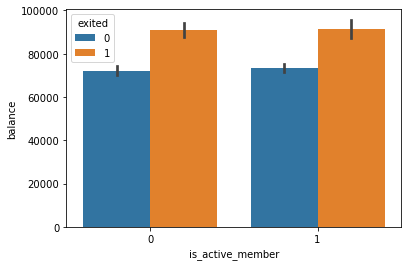

In [116]:
sns.barplot('is_active_member','balance',hue = 'exited',data=df)

<AxesSubplot:xlabel='exited', ylabel='balance'>

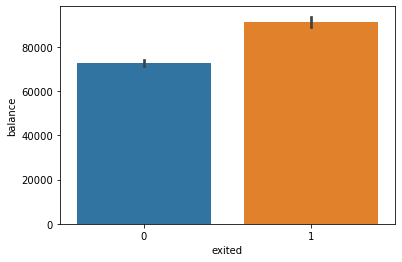

In [117]:
sns.barplot('exited','balance',data=df)

# estimated_salary

<AxesSubplot:xlabel='estimated_salary'>

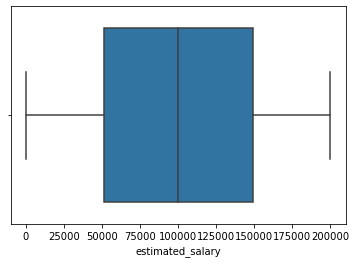

In [118]:
sns.boxplot(df['estimated_salary'])

In [119]:
df2 = df[df['exited']==1]

<AxesSubplot:xlabel='is_active_member', ylabel='balance'>

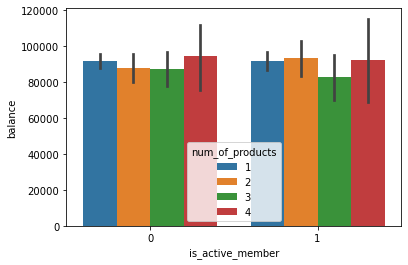

In [120]:
sns.barplot('is_active_member','balance',hue = 'num_of_products',data=df2)

<AxesSubplot:xlabel='is_active_member', ylabel='balance'>

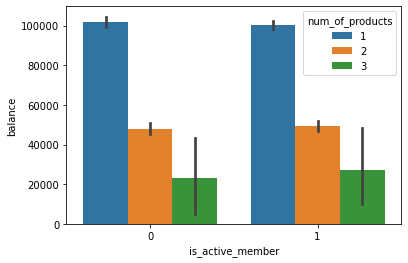

In [121]:
df3 = df[df['exited']==0]
sns.barplot('is_active_member','balance',hue = 'num_of_products',data=df3)

<AxesSubplot:xlabel='is_active_member', ylabel='balance'>

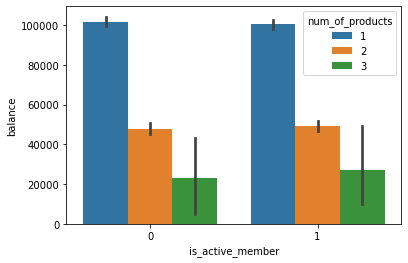

In [122]:
sns.barplot('is_active_member','balance',hue = 'num_of_products',data=df3)

<AxesSubplot:xlabel='tenure', ylabel='balance'>

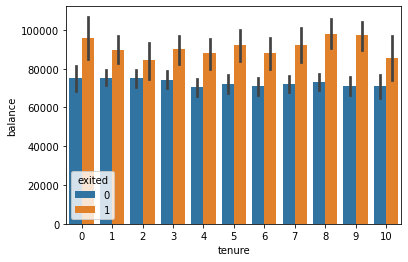

In [123]:
sns.barplot('tenure','balance',hue = 'exited',data=df)

<AxesSubplot:xlabel='balance', ylabel='credit_score'>

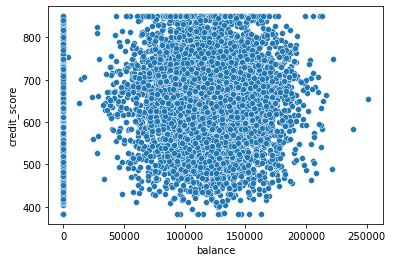

In [124]:
sns.scatterplot(df['balance'],df['credit_score'])

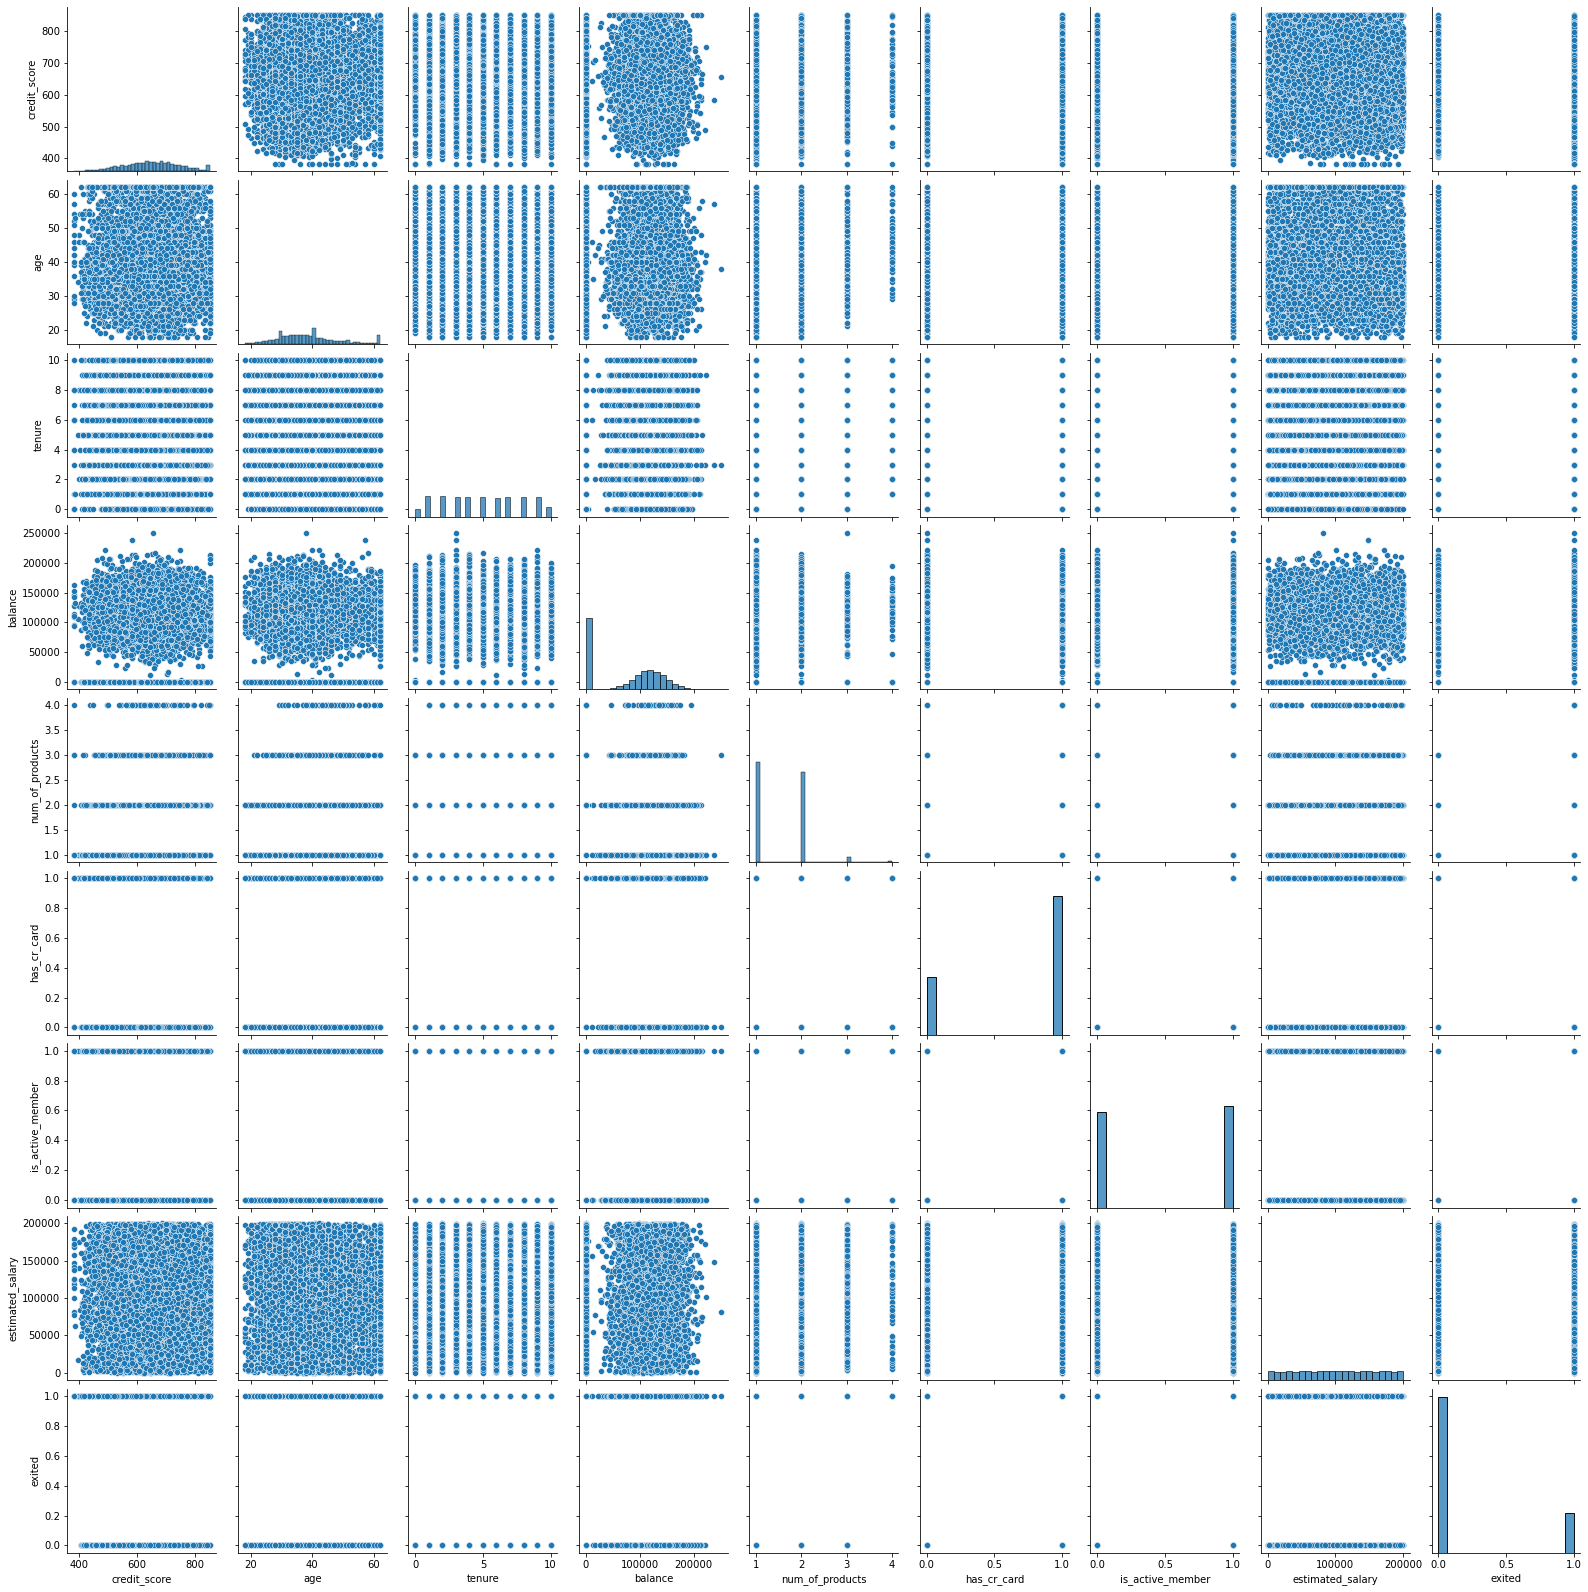

In [125]:
sns.pairplot(df)

In [126]:
# Exit % of inactive member is more

# estimated_salary

In [127]:
df['estimated_salary']

0       101348.88
1       112542.58
2       113931.57
3        93826.63
4        79084.10
          ...    
9995     96270.64
9996    101699.77
9997     42085.58
9998     92888.52
9999     38190.78
Name: estimated_salary, Length: 10000, dtype: float64

<AxesSubplot:xlabel='estimated_salary', ylabel='Count'>

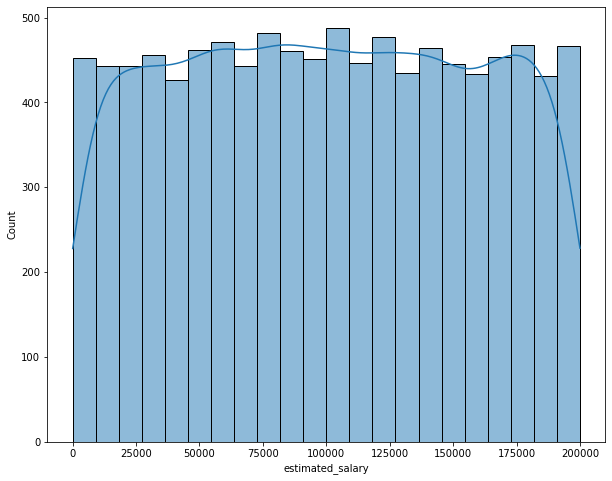

In [128]:
f = plt.figure(figsize=(10,8))
sns.histplot(df['estimated_salary'],kde=True)

<AxesSubplot:xlabel='estimated_salary'>

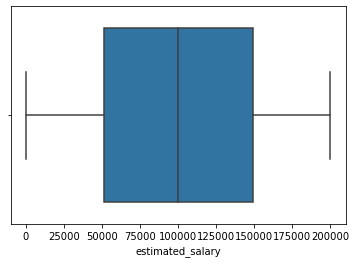

In [129]:
sns.boxplot(df['estimated_salary'])

In [130]:
dummy1 = df.copy()
dummy1["salary_reworked"] = np.where((dummy1.estimated_salary >= 0) & (dummy1.estimated_salary < 25000),"1  (0-25000)"
                                 ,np.where((dummy1.estimated_salary >= 25000) & (dummy1.estimated_salary < 50000),"2  (25000-50000)",
                                  np.where((dummy1.estimated_salary >= 50000) & (dummy1.estimated_salary < 75000),"3  (50000-75000)",
                                  np.where((dummy1.estimated_salary >= 75000) & (dummy1.estimated_salary < 100000),"4  (75000-100000)",
                                  np.where((dummy1.estimated_salary >= 100000) & (dummy1.estimated_salary < 125000),"5  (100000-125000)",
                                  np.where((dummy1.estimated_salary >= 125000) & (dummy1.estimated_salary < 150000),"6  (125000-150000)",
                                  np.where((dummy1.estimated_salary >= 150000) & (dummy1.estimated_salary < 175000),"7  (150000-175000)",'8  (175000+)')))))))

In [131]:
dummy1['salary_reworked'].unique()

array(['5  (100000-125000)', '4  (75000-100000)', '6  (125000-150000)',
       '1  (0-25000)', '3  (50000-75000)', '2  (25000-50000)',
       '8  (175000+)', '7  (150000-175000)'], dtype=object)

<AxesSubplot:xlabel='count', ylabel='salary_reworked'>

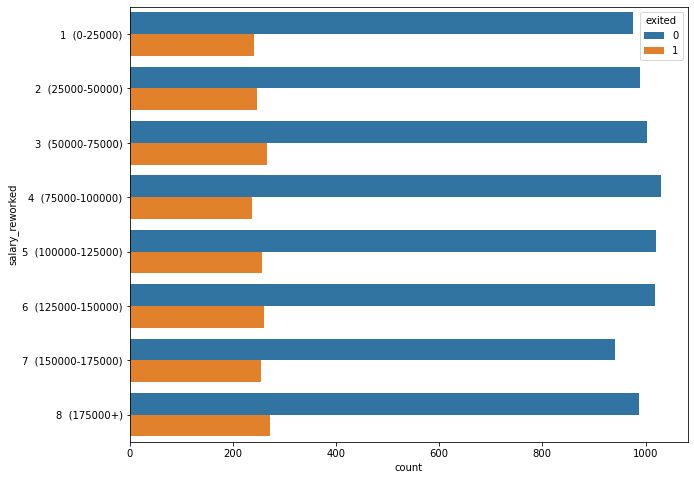

In [132]:
f = plt.figure(figsize=(10,8))

sns.countplot(y=dummy1['salary_reworked'],order =sorted(list(dummy1['salary_reworked'].unique())),
              hue = df['exited'])

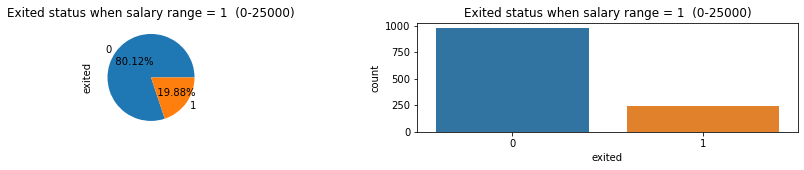

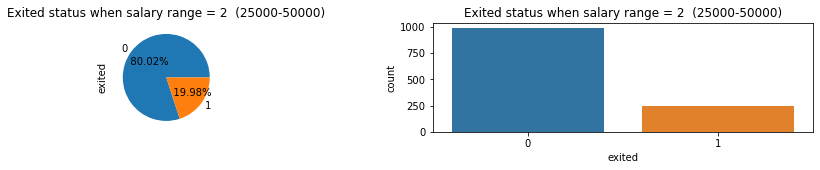

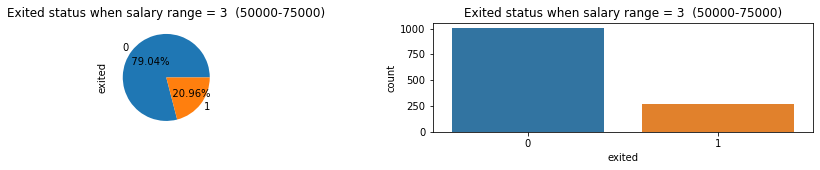

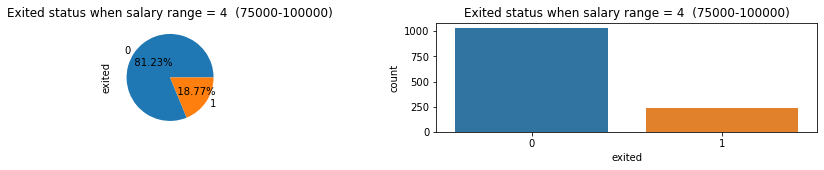

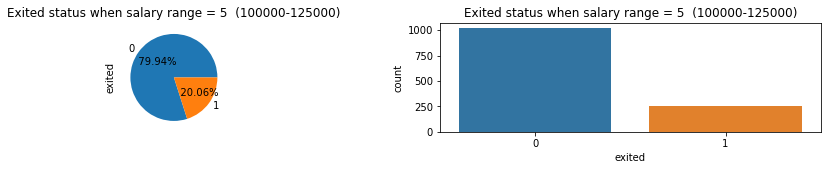

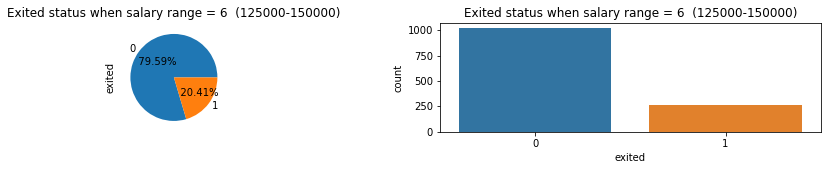

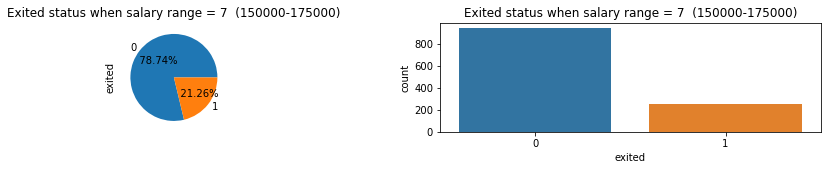

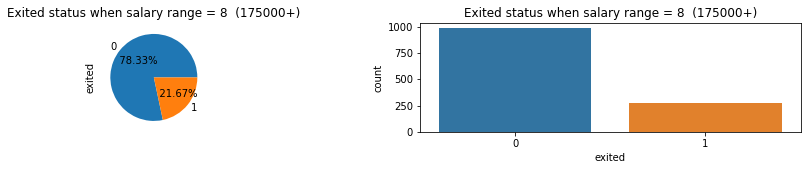

In [133]:
a=1
for i in sorted(list(dummy1['salary_reworked'].value_counts().index)):   
    if a<=dummy1['salary_reworked'].nunique():  
        f = plt.figure(figsize=(15,2))
        f.add_subplot(1,2,1)
        plt.title(f"Exited status when salary range = {i}")
        dummy1.loc[(dummy1['salary_reworked']==i)]['exited'].value_counts().plot(kind='pie',autopct='%8.2f%%')   
        f.add_subplot(1,2,2)
        plt.title(f"Exited status when salary range = {i}")
        sns.countplot(dummy1.loc[(dummy1['salary_reworked']==i)]['exited'])
        a+=1

In [134]:
# Exit % is same for almost all salary ranges

In [135]:
# df['estimated_salary']=df['estimated_salary'].apply(lambda x:np.cbrt(x))
# df['estimated_salary']

In [136]:
# f = plt.figure(figsize=(10,8))
# sns.histplot(df['estimated_salary'],kde=True)

In [137]:
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object', name='col')

In [138]:
obj_feat = []
num_feat = []
for i in list(df.columns):
    if df[i].dtype == 'O':
        obj_feat.append(i)
    else:
        num_feat.append(i)
print(f" numerical feature : \n {num_feat}")
print(f" chatagorical feature : \n {obj_feat}")

 numerical feature : 
 ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']
 chatagorical feature : 
 ['geography', 'gender']


In [139]:
for i in obj_feat:
    print(f"feature : {i}")    
    print(f"unique values : {df[i].unique()}")    
    print(f"value counts : \n{df[i].value_counts()}")
    print('_'*100)

feature : geography
unique values : ['France' 'Spain' 'Germany']
value counts : 
France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64
____________________________________________________________________________________________________
feature : gender
unique values : ['Female' 'Male']
value counts : 
Male      5457
Female    4543
Name: gender, dtype: int64
____________________________________________________________________________________________________


In [140]:
df1 = pd.get_dummies(df,drop_first=True)
df1

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


# MODEL TRAINING AND EVALUATION

In [284]:
x = df1.drop('exited',axis=1)
y = df1['exited']

In [285]:
x

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,0,1


In [286]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state=0,stratify=y)


In [287]:
# metrics = pd.DataFrame()

# Logistic Regression

In [288]:
# accuracy=[]
# for i in range(50):
#     x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=i,stratify=y)
#     log_model = LogisticRegression()
#     log_model.fit(x_train,y_train)
#     accuracy.append(log_model.score(x_test,y_test))

# random_stat = range(50)[accuracy.index(max(accuracy))]
# x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=random_stat,stratify=y)
# log_model = LogisticRegression()
# log_model.fit(x_train,y_train)
# log_model_score = log_model.score(x_test,y_test)
# log_model_recall = recall_score(y_test,log_model.predict(x_test))
# print(f'score = {log_model_score}')
# print(f'recall = {log_model_recall}')      

In [289]:
log_regression_acc = []
log_reg_recall = []
dec_tree_acc = []
dec_tree_recall = []
ran_for_acc = []
ran_for_recall = []

In [290]:
log_model = LogisticRegression()
log_model.fit(x_train,y_train)
log_model_score = log_model.score(x_test,y_test)
log_model_recall = recall_score(y_test,log_model.predict(x_test))
print(f'score = {log_model_score}')
print(f'recall = {log_model_recall}')      

score = 0.7903333333333333
recall = 0.0867430441898527


In [291]:
log_regression_acc.append(log_model_score)
log_reg_recall.append(log_model_recall)

In [292]:
log_regression_acc

[0.7903333333333333]

In [293]:
log_model.coef_[0]

array([-5.64303420e-03,  5.36330021e-02, -1.44002921e-03,  3.25560732e-06,
       -5.12212974e-04, -1.60997811e-04, -1.61769035e-03, -1.07926174e-06,
        1.02343468e-03, -4.04949912e-04, -1.25103086e-03])

In [294]:
x_train.columns

Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary',
       'geography_Germany', 'geography_Spain', 'gender_Male'],
      dtype='object')

In [295]:
log_reg_feat_imp = dict(zip(x_train.columns,log_model.coef_[0]))
log_reg_feat_imp = {key:value for key,value in sorted(log_reg_feat_imp.items() , key = lambda x : x[1])}

In [296]:
log_reg_feat_imp

{'credit_score': -0.005643034196998507,
 'is_active_member': -0.0016176903545878515,
 'tenure': -0.001440029207143137,
 'gender_Male': -0.0012510308619622745,
 'num_of_products': -0.000512212974214783,
 'geography_Spain': -0.0004049499115081212,
 'has_cr_card': -0.00016099781103411272,
 'estimated_salary': -1.079261738393658e-06,
 'balance': 3.255607321484578e-06,
 'geography_Germany': 0.0010234346838510276,
 'age': 0.05363300207372982}

<AxesSubplot:>

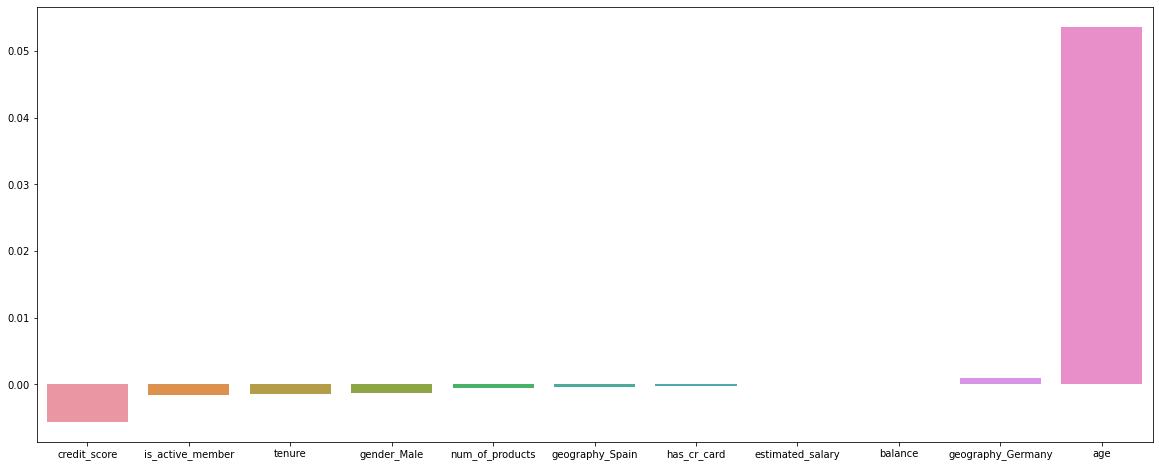

In [297]:
plt.figure(figsize=(20,8))
sns.barplot(list(log_reg_feat_imp.keys()),list(log_reg_feat_imp.values()))

# Decision Tree

In [298]:
# x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=22,stratify=y)
# accuracy=[]
# for i in range(50):
#     dec_tree = DecisionTreeClassifier(random_state =i)
#     dec_tree.fit(x_train,y_train)
#     a = dec_tree.score(x_test,y_test)
#     accuracy.append(a)
# random_stat = range(50)[accuracy.index(max(accuracy))]
# dec_tree = DecisionTreeClassifier(random_state =random_stat)
# dec_tree.fit(x_train,y_train)
# DT_model_score = dec_tree.score(x_test,y_test)
# DT_model_recall = recall_score(y_test,dec_tree.predict(x_test))
# print(f'score = {DT_model_score}')
# print(f'recall = {DT_model_recall}')   

In [299]:
dec_tree = DecisionTreeClassifier(random_state = 0)
dec_tree.fit(x_train,y_train)
DT_model_score = dec_tree.score(x_test,y_test)
DT_model_recall = recall_score(y_test,dec_tree.predict(x_test))
print(f'score = {DT_model_score}')
print(f'recall = {DT_model_recall}') 
print(classification_report(y_test,dec_tree.predict(x_test)))

score = 0.7896666666666666
recall = 0.5155482815057283
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2389
           1       0.48      0.52      0.50       611

    accuracy                           0.79      3000
   macro avg       0.68      0.69      0.68      3000
weighted avg       0.79      0.79      0.79      3000



In [300]:
dec_tree_acc.append(DT_model_score)
dec_tree_recall.append(DT_model_recall)

<BarContainer object of 11 artists>

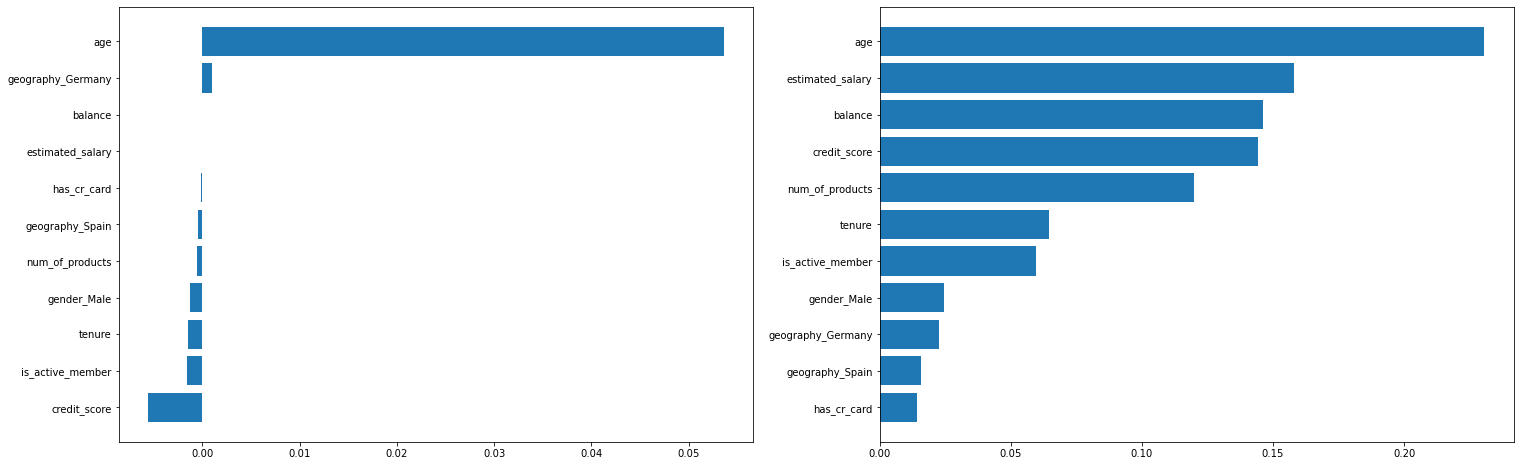

In [301]:
dec_treee_feat_importance  = dict(zip(list(x_train.columns),list(dec_tree.feature_importances_)))
dec_treee_feat_importance = {key:value for key, value in sorted(dec_treee_feat_importance.items(), key = lambda x:x[1])}
f = plt.figure(figsize=(25,8))
plt.subplot(1,2,1)
plt.barh(list(log_reg_feat_imp.keys()),list(log_reg_feat_imp.values()))
plt.subplot(1,2,2)
plt.barh(list(dec_treee_feat_importance.keys()),list(dec_treee_feat_importance.values()))

# Random Forest

In [302]:
# rand_for = RandomForestClassifier(random_state=0)
# rand_for.fit(x_train,y_train)
# rand_for.score(x_test,y_test)

In [303]:
# x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=10,stratify=y)
# accuracy=[]
# for i in range(50):
#     rand_for = RandomForestClassifier(random_state =i)
#     rand_for.fit(x_train,y_train)
#     a = rand_for.score(x_test,y_test)
#     accuracy.append(a)
# random_stat = range(50)[accuracy.index(max(accuracy))]

In [304]:
rand_for = RandomForestClassifier(random_state=0)
rand_for.fit(x_train,y_train)
RF_model_score = rand_for.score(x_test,y_test)
RF_model_recall = recall_score(y_test,rand_for.predict(x_test))
print(f'score = {RF_model_score}')
print(f'recall = {RF_model_recall}')
print(classification_report(y_test,rand_for.predict(x_test)))

score = 0.8586666666666667
recall = 0.44680851063829785
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      2389
           1       0.76      0.45      0.56       611

    accuracy                           0.86      3000
   macro avg       0.82      0.71      0.74      3000
weighted avg       0.85      0.86      0.84      3000



In [305]:
ran_for_acc.append(RF_model_score)
ran_for_recall.append(RF_model_recall)

<BarContainer object of 11 artists>

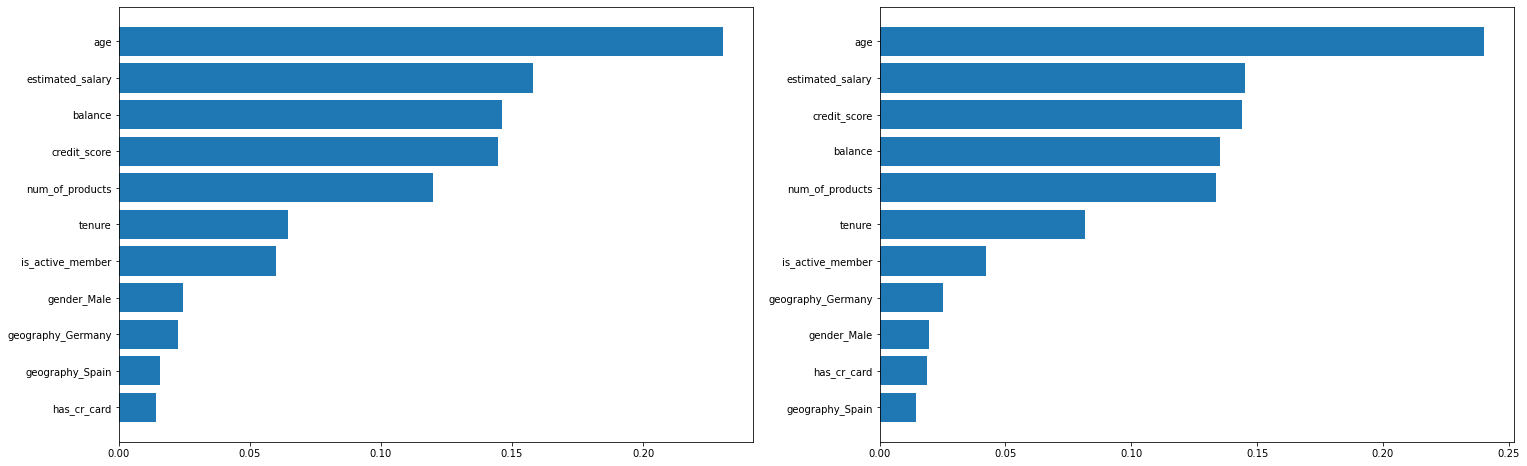

In [306]:
rand_for_feat_importance  = dict(zip(list(x_train.columns),list(rand_for.feature_importances_)))
rand_for_feat_importance = {key:value for key, value in sorted(rand_for_feat_importance.items(), key = lambda x:x[1])}
f = plt.figure(figsize=(25,8))
plt.subplot(1,2,1)
plt.barh(list(dec_treee_feat_importance.keys()),list(dec_treee_feat_importance.values()))
plt.subplot(1,2,2)
plt.barh(list(rand_for_feat_importance.keys()),list(rand_for_feat_importance.values()))

# Adaboost

In [307]:
# x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=20,stratify=y)
# ada_boost = AdaBoostClassifier(random_state=15)
# ada_boost.fit(x_train,y_train)
# ada_boost.score(x_test,y_test)

In [308]:
# x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=20,stratify=y)
# accuracy=[]
# for i in range(50):
#     ada_boost = RandomForestClassifier(random_state =i)
#     ada_boost.fit(x_train,y_train)
#     a = ada_boost.score(x_test,y_test)
#     accuracy.append(a)
# random_stat = range(50)[accuracy.index(max(accuracy))]
# ada_boost = AdaBoostClassifier(random_state=random_stat)
# ada_boost.fit(x_train,y_train)
# AB_model_score = ada_boost.score(x_test,y_test)
# AB_model_recall = recall_score(y_test,ada_boost.predict(x_test))
# print(f'score = {AB_model_score}')
# print(f'recall = {AB_model_recall}')

In [309]:
ada_boost = AdaBoostClassifier(random_state=0)
ada_boost.fit(x_train,y_train)
AB_model_score = ada_boost.score(x_test,y_test)
AB_model_recall = recall_score(y_test,ada_boost.predict(x_test))
print(f'score = {AB_model_score}')
print(f'recall = {AB_model_recall}')

score = 0.8443333333333334
recall = 0.425531914893617


<BarContainer object of 11 artists>

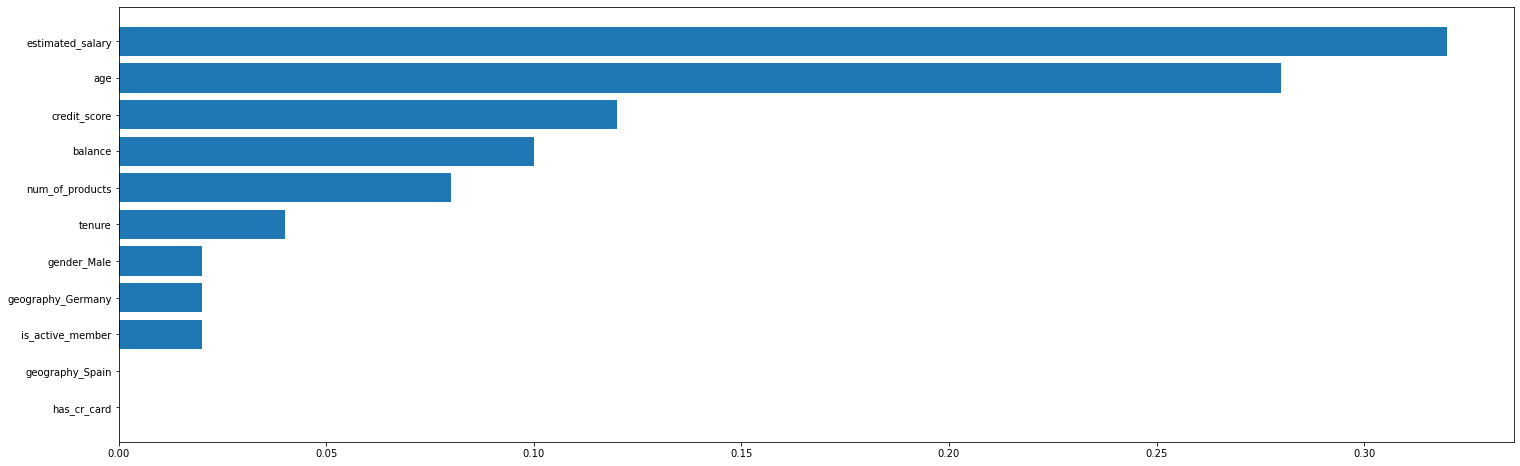

In [310]:
ada_boost_feat_importance  = dict(zip(list(x_train.columns),list(ada_boost.feature_importances_)))
ada_boost_feat_importance = {key:value for key, value in sorted(ada_boost_feat_importance.items(), key = lambda x:x[1])}
f = plt.figure(figsize=(25,8))
plt.barh(list(ada_boost_feat_importance.keys()),list(ada_boost_feat_importance.values()))

# KNN

In [311]:
normal_scale = MinMaxScaler()
norm_x_train = normal_scale.fit_transform(x_train)
norm_x_train =pd.DataFrame(norm_x_train,columns = x.columns)
norm_x_test = normal_scale.transform(x_test)
norm_x_test =pd.DataFrame(norm_x_test,columns = x.columns)

In [312]:
# neighb = []
# accuracy = []
# for i in range(3,51,2):
#     neighb.append(i)
#     knn_model = KNeighborsClassifier(n_neighbors = i)
#     knn_model.fit(norm_x_train,y_train)  
#     a = knn_model.score(norm_x_test,y_test)
#     accuracy.append(a)
# neighbors = range(3,51,2)[accuracy.index(max(accuracy))]
# knn_model = KNeighborsClassifier(n_neighbors = neighbors)
# knn_model.fit(norm_x_train,y_train)  
# KNN_model_score = knn_model.score(norm_x_test,y_test)
# KNN_model_recall = recall_score(y_test,knn_model.predict(norm_x_test))
# print(f'score = {KNN_model_score}')
# print(f'recall = {KNN_model_recall}')

In [313]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(norm_x_train,y_train)  
KNN_model_score = knn_model.score(norm_x_test,y_test)
KNN_model_recall = recall_score(y_test,knn_model.predict(norm_x_test))
print(f'score = {KNN_model_score}')
print(f'recall = {KNN_model_recall}')

score = 0.814
recall = 0.353518821603928


In [314]:
metrics = pd.DataFrame({
                        'model':['Logistic_Regression','Decision_Tree','Random_Forest','Adaboost','KNN'],
                        'accuracy': [log_model_score,DT_model_score,RF_model_score,AB_model_score,KNN_model_score],
                        'recall':[log_model_recall,DT_model_recall,RF_model_recall,AB_model_recall,KNN_model_recall]
                      })

In [315]:
metrics

,model,accuracy,recall
0,Logistic_Regression,0.790333,0.086743
1,Decision_Tree,0.789667,0.515548
2,Random_Forest,0.858667,0.446809
3,Adaboost,0.844333,0.425532
4,KNN,0.814000,0.353519


In [316]:
import pickle

In [317]:
model = pickle.dump(rand_for,open("model.pkl","wb"))

In [318]:
# columns = list(a.keys())
# columns

In [319]:
a = {"credit_score": 697,
 "age": 25.0,
 "tenure": 1.0,
 "balance": 0.0,
 "num_of_products": 2.0,
 "has_cr_card": 0.0,
 "is_active_member": 0.0,
 "estimated_salary": 87803.32,
 "geography": "Germany",
 "geography": "Spain",
 "gender": "Male"}
columns_dict = {"col_name": list(a.keys())}
columns_dict

{'col_name': ['credit_score',
  'age',
  'tenure',
  'balance',
  'num_of_products',
  'has_cr_card',
  'is_active_member',
  'estimated_salary',
  'geography',
  'gender']}

In [320]:
import json

In [321]:
with open('Columns_name.json','w') as json_file:
    json.dump(columns_dict,json_file)

<BarContainer object of 11 artists>

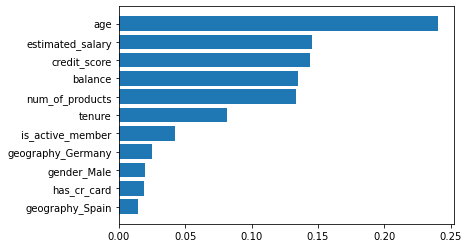

In [322]:
feature_importance = pd.DataFrame()
feature_importance['Columns'] = x.columns
feature_importance['Importance'] = rand_for.feature_importances_
feature_importance.sort_values('Importance',ascending=True , inplace = True)
feature_importance
plt.barh(feature_importance.Columns,feature_importance.Importance)

# Handle imbalanced data

In [323]:
import imblearn
from imblearn.over_sampling import SMOTE 

sm = SMOTE(sampling_strategy=0.8,k_neighbors=5,random_state = 100) 
X_train_res, y_train_res = sm.fit_sample(x_train, y_train) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

After OverSampling, the shape of train_X: (10033, 11)
After OverSampling, the shape of train_y: (10033,) 

After OverSampling, counts of label '1': 4459
After OverSampling, counts of label '0': 5574


# Logistic

In [324]:
log_model = LogisticRegression()
log_model.fit(X_train_res,y_train_res)
log_model_score = log_model.score(x_test,y_test)
log_model_recall = recall_score(y_test,log_model.predict(x_test))
print(f'score = {log_model_score}')
print(f'recall = {log_model_recall}')    
log_regression_acc.append(log_model_score)
log_reg_recall.append(log_model_recall)

score = 0.6966666666666667
recall = 0.5450081833060556


# dec tree

In [325]:
dec_tree = DecisionTreeClassifier(random_state = 0)
dec_tree.fit(X_train_res,y_train_res)
DT_model_score = dec_tree.score(x_test,y_test)
DT_model_recall = recall_score(y_test,dec_tree.predict(x_test))
print(f'score = {DT_model_score}')
print(f'recall = {DT_model_recall}') 
print(classification_report(y_test,dec_tree.predict(x_test)))
dec_tree_acc.append(DT_model_score)
dec_tree_recall.append(DT_model_recall)

score = 0.753
recall = 0.5662847790507365
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      2389
           1       0.42      0.57      0.48       611

    accuracy                           0.75      3000
   macro avg       0.65      0.68      0.66      3000
weighted avg       0.79      0.75      0.77      3000



# random Forest

In [326]:
rand_for = RandomForestClassifier(random_state=0)
rand_for.fit(X_train_res,y_train_res)
RF_model_score = rand_for.score(x_test,y_test)
RF_model_recall = recall_score(y_test,rand_for.predict(x_test))
print(f'score = {RF_model_score}')
print(f'recall = {RF_model_recall}')
print(classification_report(y_test,rand_for.predict(x_test)))
ran_for_acc.append(RF_model_score)
ran_for_recall.append(RF_model_recall)

score = 0.819
recall = 0.563011456628478
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2389
           1       0.55      0.56      0.56       611

    accuracy                           0.82      3000
   macro avg       0.72      0.72      0.72      3000
weighted avg       0.82      0.82      0.82      3000



# Comparison

In [327]:
procedure = ['imbalanced', 'balanced']

Text(0.5, 1.0, 'random forest recall change')

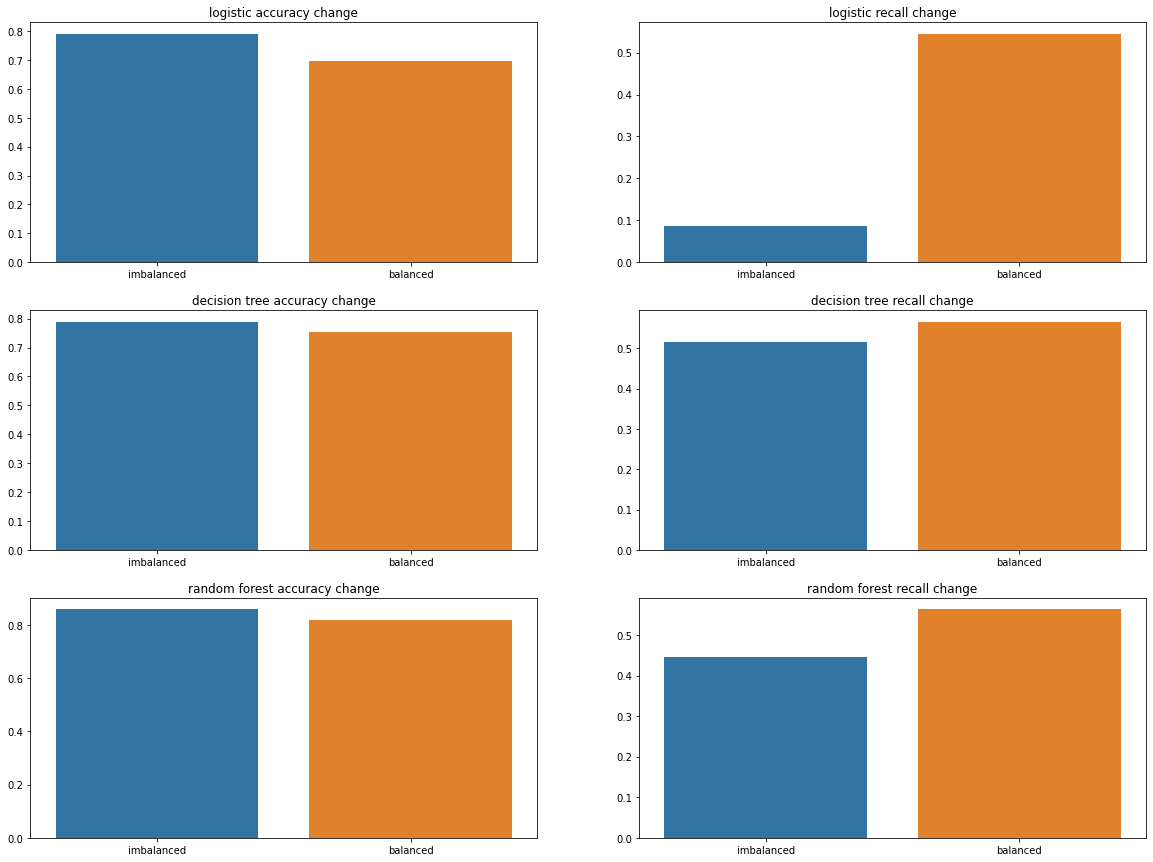

In [328]:
f = plt.figure(figsize=(20,15))

f.add_subplot(3,2,1)
sns.barplot(procedure,log_regression_acc)
plt.title('logistic accuracy change')
# plt.xticks(rotation=45)
f.add_subplot(3,2,2)
# plt.xticks(rotation=45)
sns.barplot(procedure,log_reg_recall)
plt.title('logistic recall change')
# plt.xticks(rotation=45)
f.add_subplot(3,2,3)
sns.barplot(procedure,dec_tree_acc)
plt.title('decision tree accuracy change')
# plt.xticks(rotation=45)
f.add_subplot(3,2,4)
sns.barplot(procedure,dec_tree_recall)
plt.title('decision tree recall change')
# plt.xticks(rotation=45)
f.add_subplot(3,2,5)
sns.barplot(procedure,ran_for_acc)
plt.title('random forest accuracy change')
# plt.xticks(rotation=45)
f.add_subplot(3,2,6)
sns.barplot(procedure,ran_for_recall)
plt.title('random forest recall change')
# plt.xticks(rotation=45)